# Debugging dask workflows: Detrending part 1

Detrending - subtracting a trend, commonly a linear fit, from the data - along the time dimension is a common workflow in the climate sciences. 

Detrending with dask is a consistent source of headaches:
1. [Polyfit performance on large datasets - Suboptimal dask task graph](https://github.com/pydata/xarray/issues/5629)
1. [Unexpected chunking of 3d DataArray in polyfit()](https://github.com/pydata/xarray/issues/4554)
1. [Memory errors with detrending + rolling operations](https://github.com/pydata/xarray/discussions/6280)

## Challenges of detrending

We usually want to subtract a linear trend in time. Detrending has 3 steps:
1. Fit a polynomial using polyfit
2. Evaluate the trend using polyval and the fit coefficients
3. Subtract the trend from the original data

``` python
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg, skipna=False)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit
```

The main challenge is that model output is usually chunked with small chunksizes in time, and big chunksizes in space. Naively calling `polyfit` along time using `xarray.apply_ufunc(numpy.polyfit, ..., dask="parallelized")` would a require rechunking the dataset. This could be a good way to proceed if there are other time-series analyses that will be performed. In that case use [rechunker](https://rechunker.readthedocs.io/en/latest/). 

[`DataArray.polyfit`](https://xarray.pydata.org/en/latest/generated/xarray.DataArray.polyfit.html) does actually support fitting along chunked dimensions. It uses [`dask.array.linalg.lstsq`](https://docs.dask.org/en/stable/generated/dask.array.linalg.lstsq.html) for an out-of-core parallel fitting algorithm. 

However the limitation of `lstsq` is that it requires 2D arrays as input, but our model output is 3D or 4D (time, depth, lat, lon). `polyfit` uses [`DataArray.stack`](https://xarray.pydata.org/en/latest/generated/xarray.DataArray.stack.html) to reshape all arrays to 2D, does the fit, and reshapes back. Easy, no?

Turns out.. not easy. Reshaping in parallel can be really expensive! The [dask docs](https://docs.dask.org/en/stable/array-chunks.html#reshaping) illustrate this well. We have a [possible solution](https://github.com/pydata/xarray/issues/5629#issuecomment-960133879) but this hasn't been implemented yet. It also turned out that this wasn't the issue that affected  [Memory errors with detrending + rolling operations](https://github.com/pydata/xarray/discussions/6280)


In this notebook, I explore the detrending problem a little bit to find what other challenges affect detrending workflows.

## Summary

1. We use simple techniques like tracking chunk sizes and number of tasks to isolate a few problems, particularly in `polyval`
1. Fixing `polyval` doesn't improve the calculation, so we then examine the dask graph for `polyfit` in a smaller artificial problem that replicates the main issues.
1. This lets us trace the issue back to a serious [regression](https://github.com/dask/dask/issues/6916) in dask's `tensordot` function.
1. That issue has since been [fixed](https://github.com/dask/dask/pull/7980) (available in `dask >= 2022.03.0`)
1. Now things work well!

```{note} 
The first half of this notebook was built with `dask==2021.12.0`.
```

## Setup

In [1]:
import dask.array
import distributed
import numpy as np
import xarray as xr
from IPython.display import Image

In [2]:
client = distributed.Client()
client

<Client: 'tcp://127.0.0.1:61123' processes=4 threads=8, memory=16.00 GiB>

## Example detrending operation

I'll use the example dataset in [Memory errors with detrending + rolling operations](https://github.com/pydata/xarray/discussions/6280) but make it smaller in time

In [3]:
nt = 8772 // 4
ny = 489
nx = 655
# chunks like the data is stored on disk
# small in time, big in space
# because the chunk sizes are -1 along lat, lon;
# reshaping this array to (time, latlon) prior to fitting is pretty cheap
chunks = (8, -1, -1)

da = xr.DataArray(
    dask.array.random.random((nt, ny, nx), chunks=chunks),
    dims=("ocean_time", "eta_rho", "xi_rho"),
)
da

<xarray.DataArray 'random_sample-ffbb27b2e849e89719a8455875172787' (
                                                                    ocean_time: 2193,
                                                                    eta_rho: 489,
                                                                    xi_rho: 655)>
dask.array<random_sample, shape=(2193, 489, 655), dtype=float64, chunksize=(8, 489, 655), chunktype=numpy.ndarray>
Dimensions without coordinates: ocean_time, eta_rho, xi_rho

In [4]:
# Function to detrend
# Source: https://gist.github.com/rabernat/1ea82bb067c3273a6166d1b1f77d490f
def detrend_dim(da, dim, deg=1):
    """detrend along a single dimension."""
    # calculate polynomial coefficients
    p = da.polyfit(dim=dim, deg=deg, skipna=False)
    # evaluate trend
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    # remove the trend
    return da - fit


detrended = detrend_dim(da, dim="ocean_time")
detrended

<xarray.DataArray (ocean_time: 2193, eta_rho: 489, xi_rho: 655)>
dask.array<sub, shape=(2193, 489, 655), dtype=float64, chunksize=(8, 489, 655), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) int64 0 1 2 3 4 5 ... 2187 2188 2189 2190 2191 2192
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 482 483 484 485 486 487 488
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 648 649 650 651 652 653 654

```{warning} 
The dask dashboard screenshot for the following cell was captured with dask 2021.12.0.
```

In [ ]:
detrended.compute()

Calling compute doesn't work so well and that single `tensordot` task looks funny. We have many input chunks and many output chunks. It's not good if there's a single task that might be a bottleneck by accumulating many input chunks.

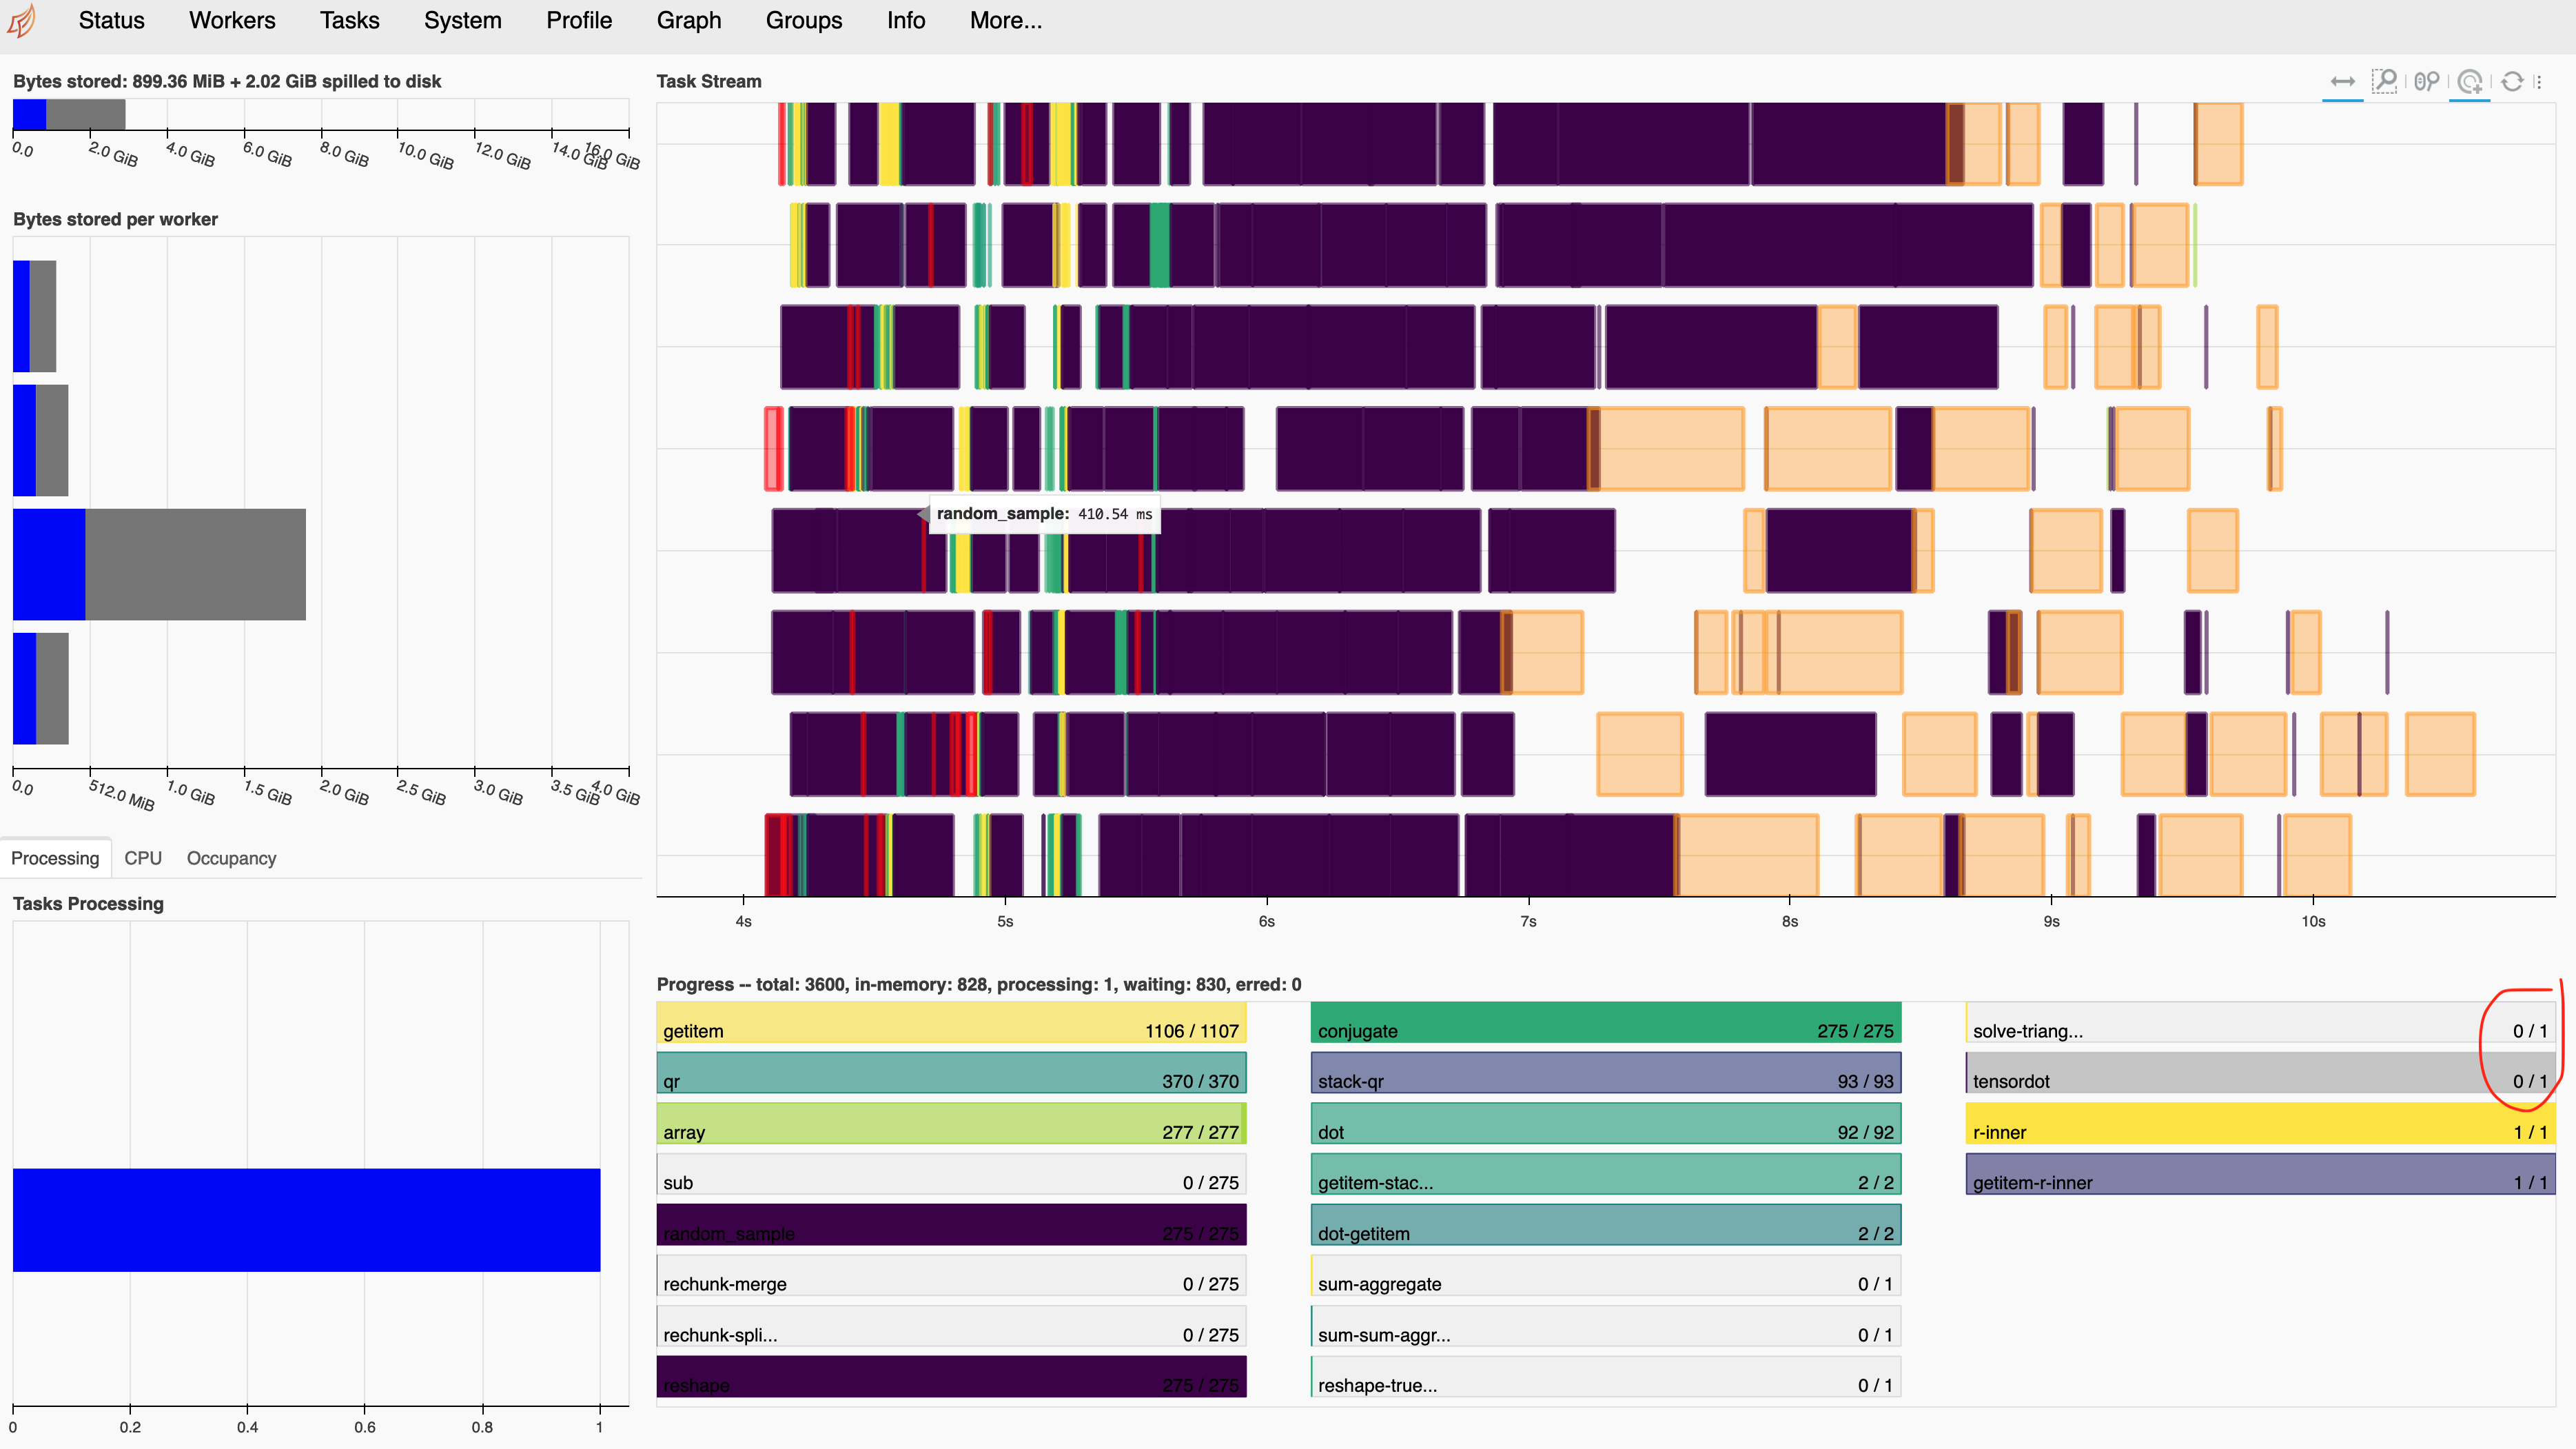

In [5]:
Image("../images/detrend-dask-dashboard-1.png")

What is going wrong?

## Lets look at detrend

Detrend has 3 steps:
1. polyfit
2. polyval
3. subtract

``` python
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg, skipna=False)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit
```

First lets try just `polyfit`

In [5]:
# these are arguments provided to detrend
dim = "ocean_time"
deg = 1

p = da.polyfit(dim=dim, deg=deg, skipna=False)
p

<xarray.Dataset>
Dimensions:               (eta_rho: 489, xi_rho: 655, degree: 2)
Coordinates:
  * eta_rho               (eta_rho) int64 0 1 2 3 4 5 ... 484 485 486 487 488
  * xi_rho                (xi_rho) int64 0 1 2 3 4 5 ... 649 650 651 652 653 654
  * degree                (degree) int64 1 0
Data variables:
    polyfit_coefficients  (degree, eta_rho, xi_rho) float64 dask.array<chunksize=(2, 489, 655), meta=np.ndarray>

Seems OK by which I mean input chunks == output chunks

How about polyval?

In [6]:
fit = xr.polyval(da[dim], p.polyfit_coefficients)
fit

<xarray.DataArray (ocean_time: 2193, eta_rho: 489, xi_rho: 655)>
dask.array<sum-aggregate, shape=(2193, 489, 655), dtype=float64, chunksize=(2193, 489, 655), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) int64 0 1 2 3 4 5 ... 2187 2188 2189 2190 2191 2192
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 482 483 484 485 486 487 488
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 648 649 650 651 652 653 654

Aha! Now suddenly we have one giant chunk for the entire array!

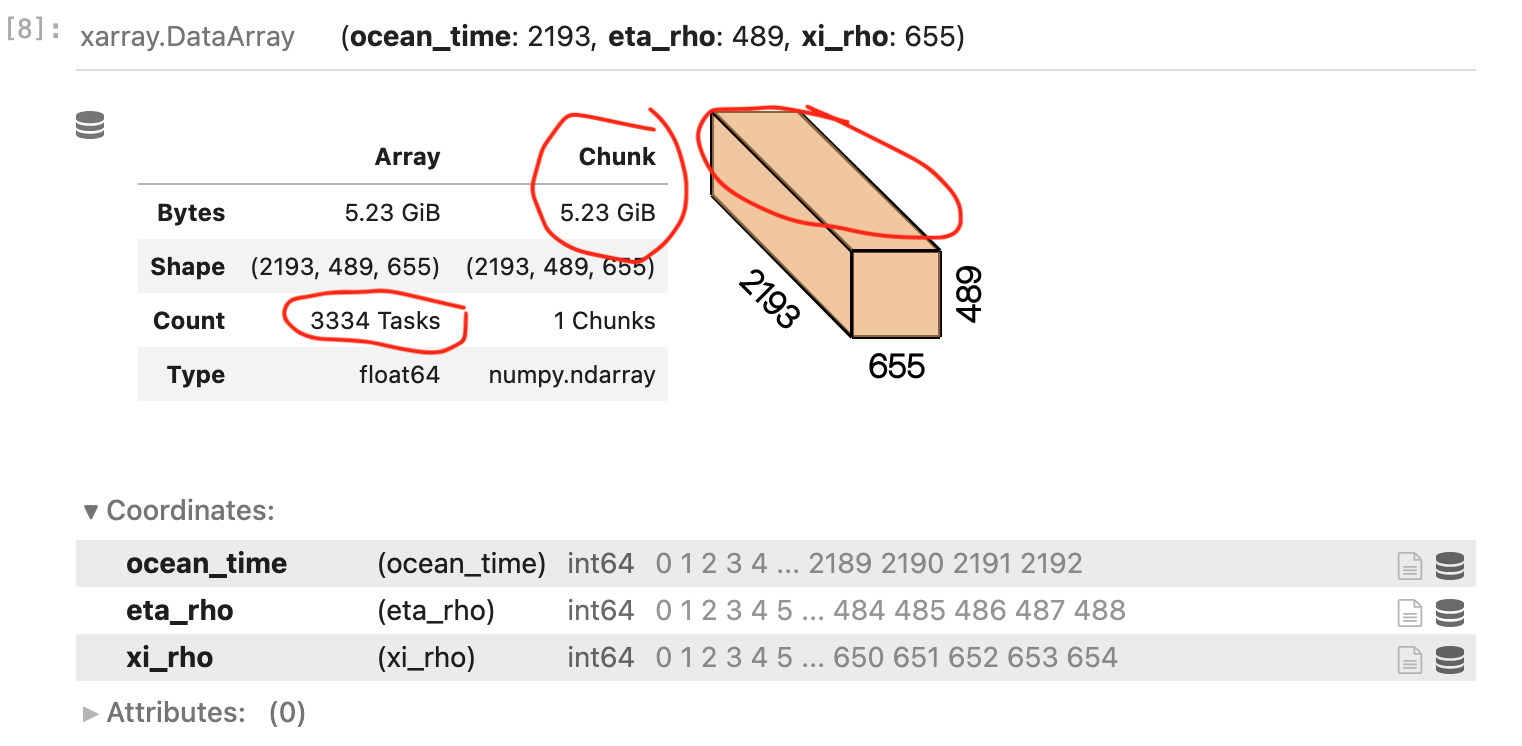

In [8]:
Image("../images/dask-repr.png")

```{tip} The first step to checking your dask workflow is to look for sudden and large changes in number of tasks or chunk size. Pay attention to the dask repr.
```

## Building a better polyval

This required looking at the code of [polyval](https://github.com/pydata/xarray/blob/f8bae5974ee2c3f67346298da12621af4cae8cf8/xarray/core/computation.py#L1847).

```python
def polyval(coord, coeffs, degree_dim="degree"):
    from .dataarray import DataArray
    from .missing import get_clean_interp_index


    x = get_clean_interp_index(coord, coord.name, strict=False)


    deg_coord = coeffs[degree_dim]


    lhs = DataArray(
        np.vander(x, int(deg_coord.max()) + 1),
        dims=(coord.name, degree_dim),
        coords={coord.name: coord, degree_dim: np.arange(deg_coord.max() + 1)[::-1]},
    )
    return (lhs * coeffs).sum(degree_dim)
```

We call this using
```python
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
```
The core issue is that the `da[dim]` coord is unchunked. So `lhs` is a numpy array, which when combined with the `coeffs` (dask array) gives us a dask array with a single 5GB chunk

In [7]:
da[dim]

<xarray.DataArray 'ocean_time' (ocean_time: 2193)>
array([   0,    1,    2, ..., 2190, 2191, 2192])
Dimensions without coordinates: ocean_time

Let's instead create a chunked "ocean_time" coordinate. This is a little roundabout because Xarray [doesn't let you](https://github.com/pydata/xarray/issues/6204) chunk dimension coordinates using `.chunk`.

In [8]:
# first create a chunked version of the "ocean_time" dimension
chunked_dim = xr.DataArray(
    dask.array.from_array(da[dim].data, chunks=da.chunksizes[dim]), dims=dim, name=dim
)
chunked_dim

<xarray.DataArray 'ocean_time' (ocean_time: 2193)>
dask.array<array, shape=(2193,), dtype=int64, chunksize=(8,), chunktype=numpy.ndarray>
Dimensions without coordinates: ocean_time

This little bit is a rewritted version of polyval that can handle a chunked `coord` as input.
```{note} 
This function will not work properly for an actual time coordinate. Here ocean_time is just ints. If it were a datetime vector, we would need to convert that to a vector of floats or ints.
```

In [9]:
def polyval(coord, coeffs, degree_dim="degree"):
    x = coord.data

    deg_coord = coeffs[degree_dim]
    N = int(deg_coord.max()) + 1

    lhs = xr.DataArray(
        np.stack([x ** (N - 1 - i) for i in range(N)], axis=1),
        dims=(coord.name, degree_dim),
        coords={coord.name: coord, degree_dim: np.arange(deg_coord.max() + 1)[::-1]},
    )
    return (lhs * coeffs).sum(degree_dim)


fit = polyval(chunked_dim, p.polyfit_coefficients)
fit

<xarray.DataArray (ocean_time: 2193, eta_rho: 489, xi_rho: 655)>
dask.array<sum-aggregate, shape=(2193, 489, 655), dtype=float64, chunksize=(8, 489, 655), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) int64 0 1 2 3 4 5 ... 2187 2188 2189 2190 2191 2192
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 482 483 484 485 486 487 488
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 648 649 650 651 652 653 654

## An older dask version

```{warning} 
the following cells describe an issue present for `dask>2.30.0` and `dask < 2022.03.0`.
```

This is a much better `fit` but we still have issues computing  it.

In [ ]:
fit.compute()

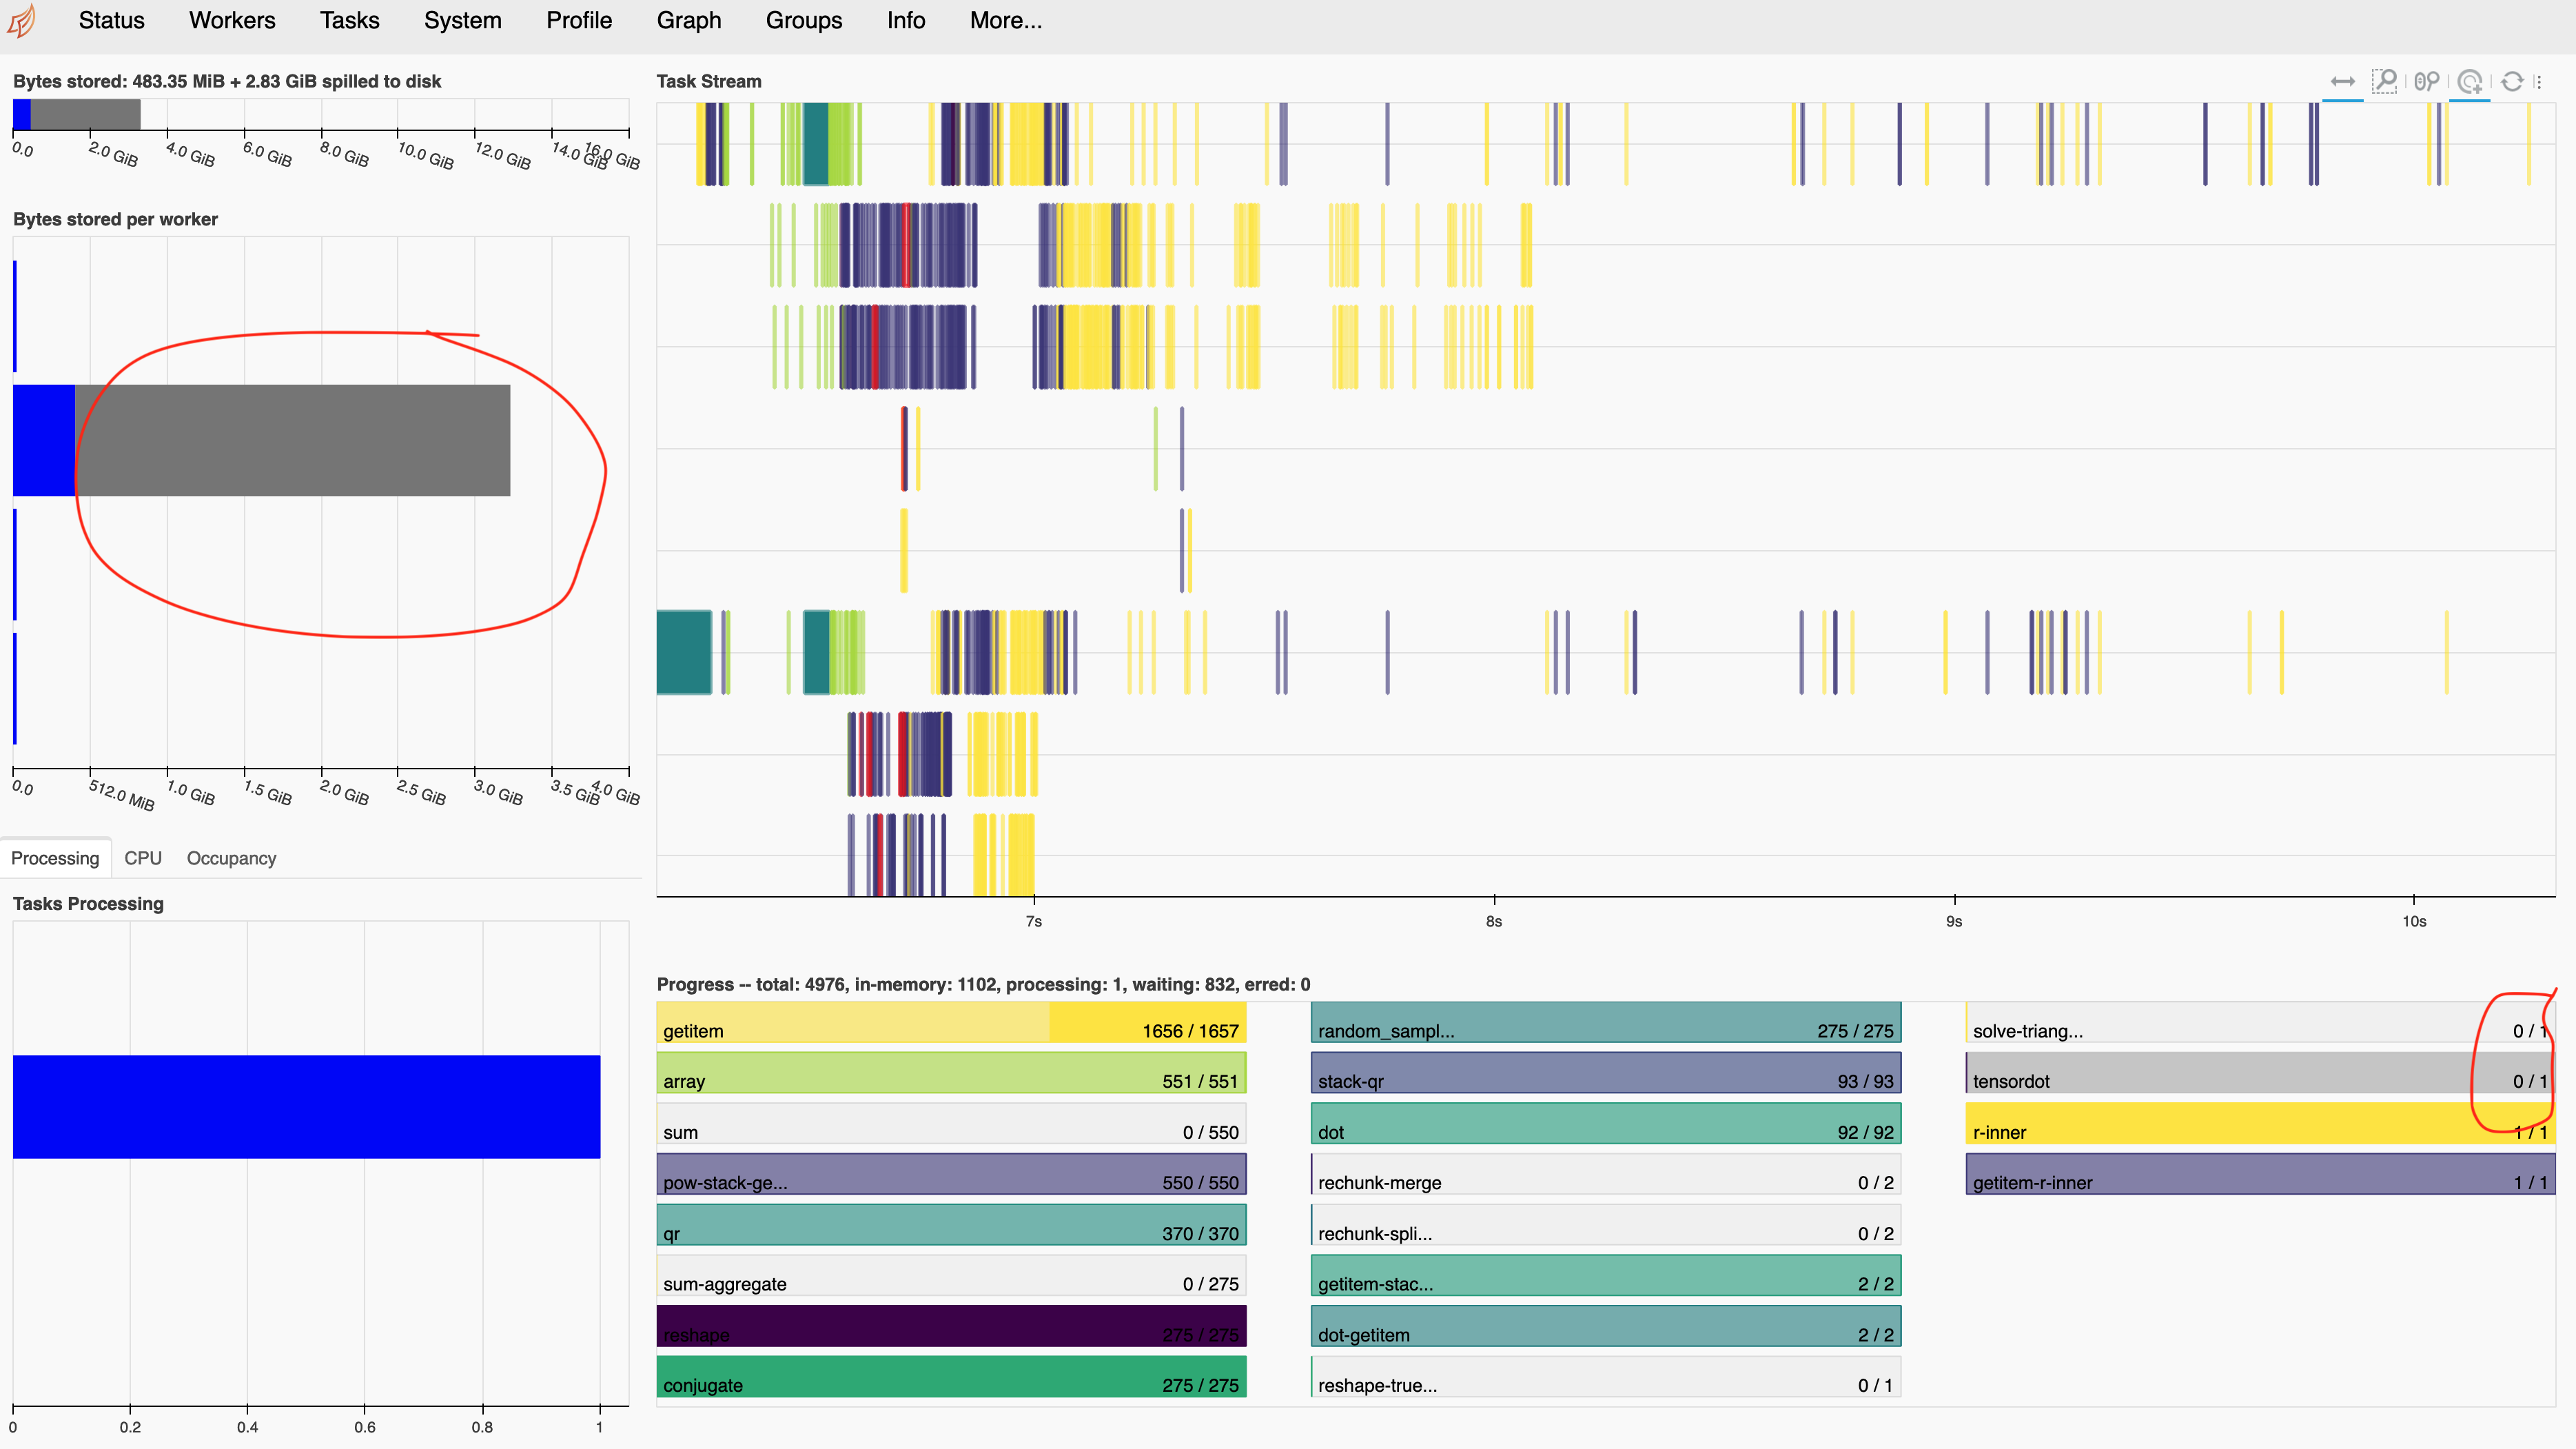

In [11]:
Image("../images/detrend-dask-dashboard-2.png")

Hmm.... that single `tensordot` task still looks problematic. It is probably why we see very skewed memory consumption (mostly one worker). 

Sadly and surprisingly, that wasn't fixed by our new polyval !

### Let's look at polyfit again

#### A dask bug

But now for a much smaller problem.

```{tip} 
Visualizing the dask graph can sometimes be instructive but really only works for small problems. Usually we want to see long parallel chains.
```

In [10]:
nt = 24
ny = 489
nx = 655
chunks = (8, -1, -1)

smol_da = xr.DataArray(
    dask.array.random.random((nt, ny, nx), chunks=chunks),
    dims=("ocean_time", "eta_rho", "xi_rho"),
)
smol_da

<xarray.DataArray 'random_sample-267f8112b7b54af2dbd898356bfcb6f7' (
                                                                    ocean_time: 24,
                                                                    eta_rho: 489,
                                                                    xi_rho: 655)>
dask.array<random_sample, shape=(24, 489, 655), dtype=float64, chunksize=(8, 489, 655), chunktype=numpy.ndarray>
Dimensions without coordinates: ocean_time, eta_rho, xi_rho

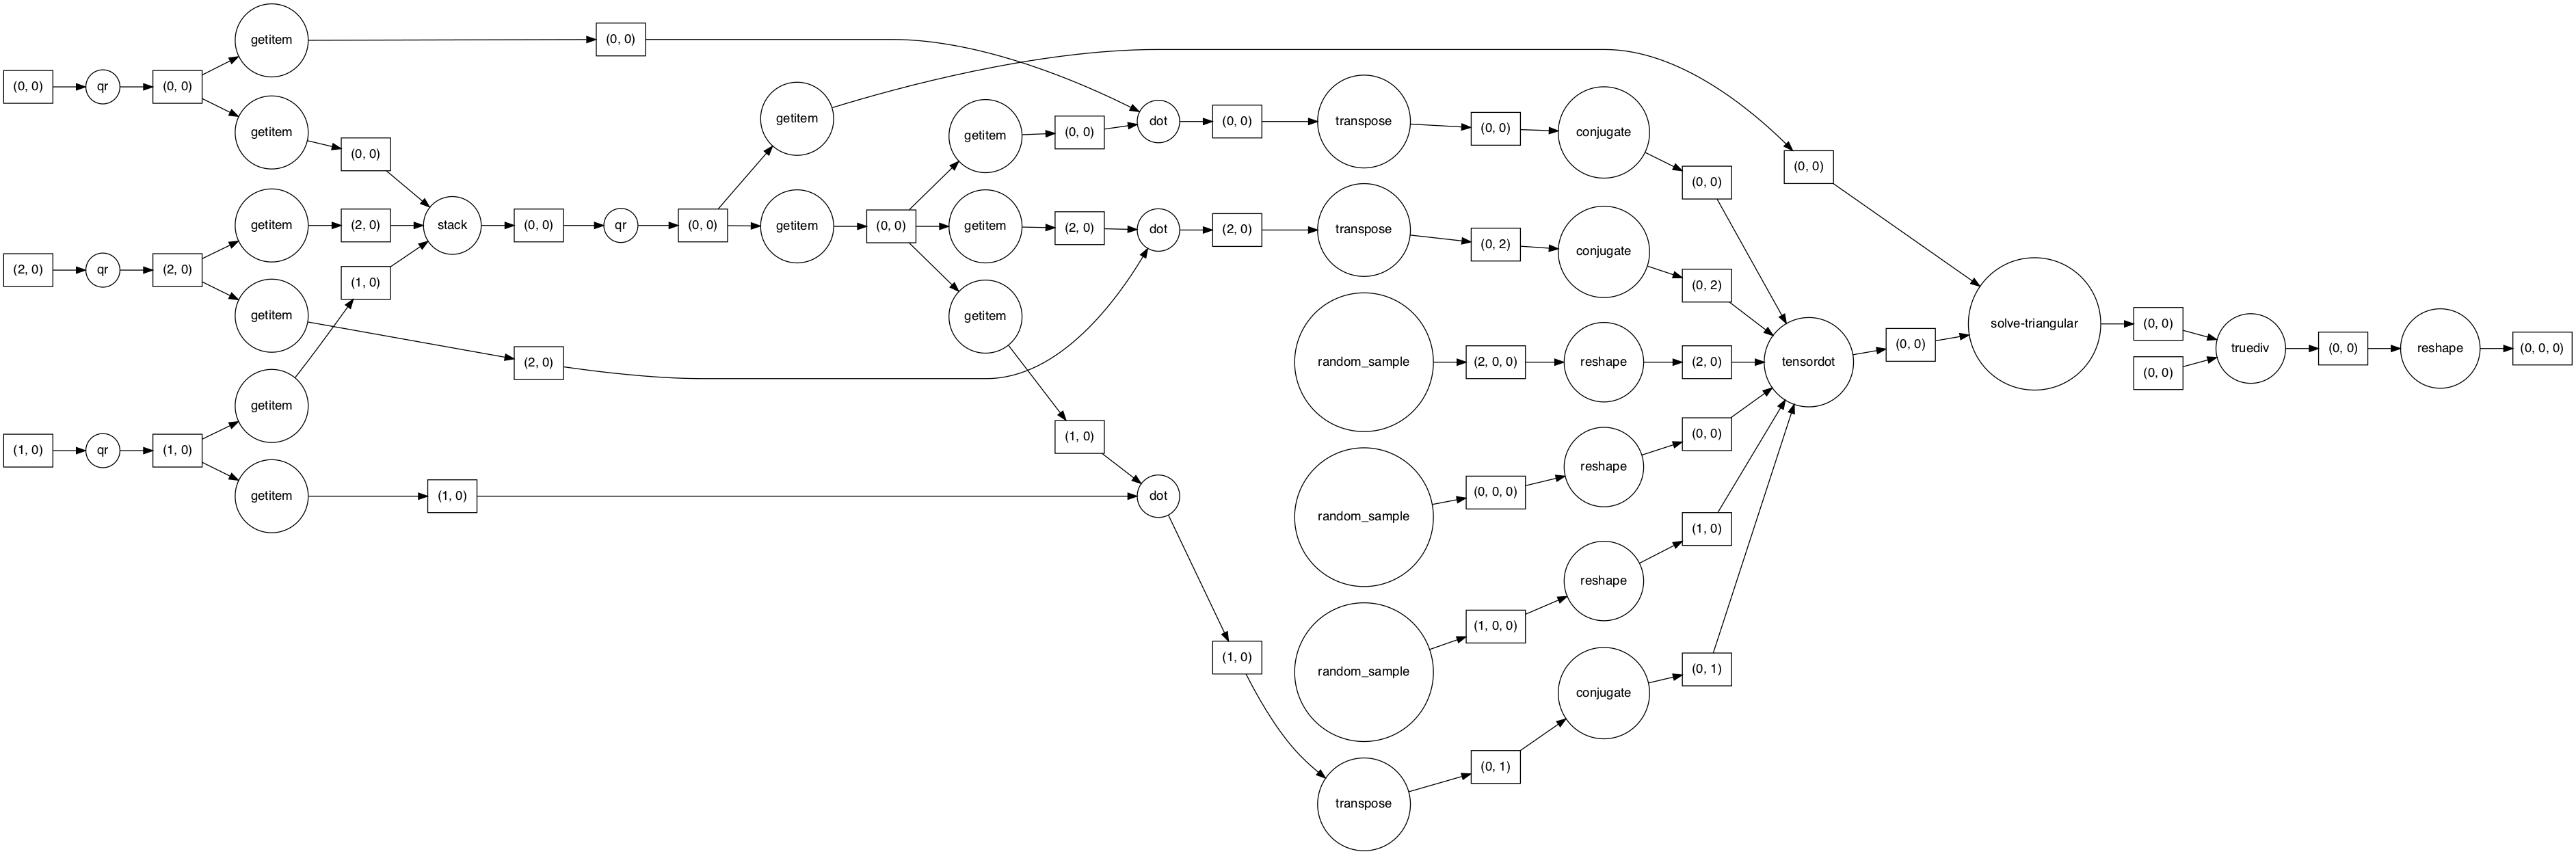

In [15]:
p = smol_da.polyfit(dim="ocean_time", deg=1, skipna=False)
dask.visualize(p, rankdir="LR")

Ouch. we see all the tasks go through a single `tensordot` task. 

This cannot work well. It effectively means that one worker is going to receive all time steps as a single chunk, which implies a lot of memory use and network transfer.

Searching the  dask issue tracker leads to [this issue](https://github.com/dask/dask/issues/6916) so we were stuck.

## Is it fixed?

Thanks to some [upstream work](https://github.com/dask/dask/pull/7980) in dask, we expect the `tensordot` problem is fixed. So let's try  it again

Upgrading dask to `dask==2022.03.0` shows a much better graph.

In [16]:
dask.__version__

'2022.03.0'

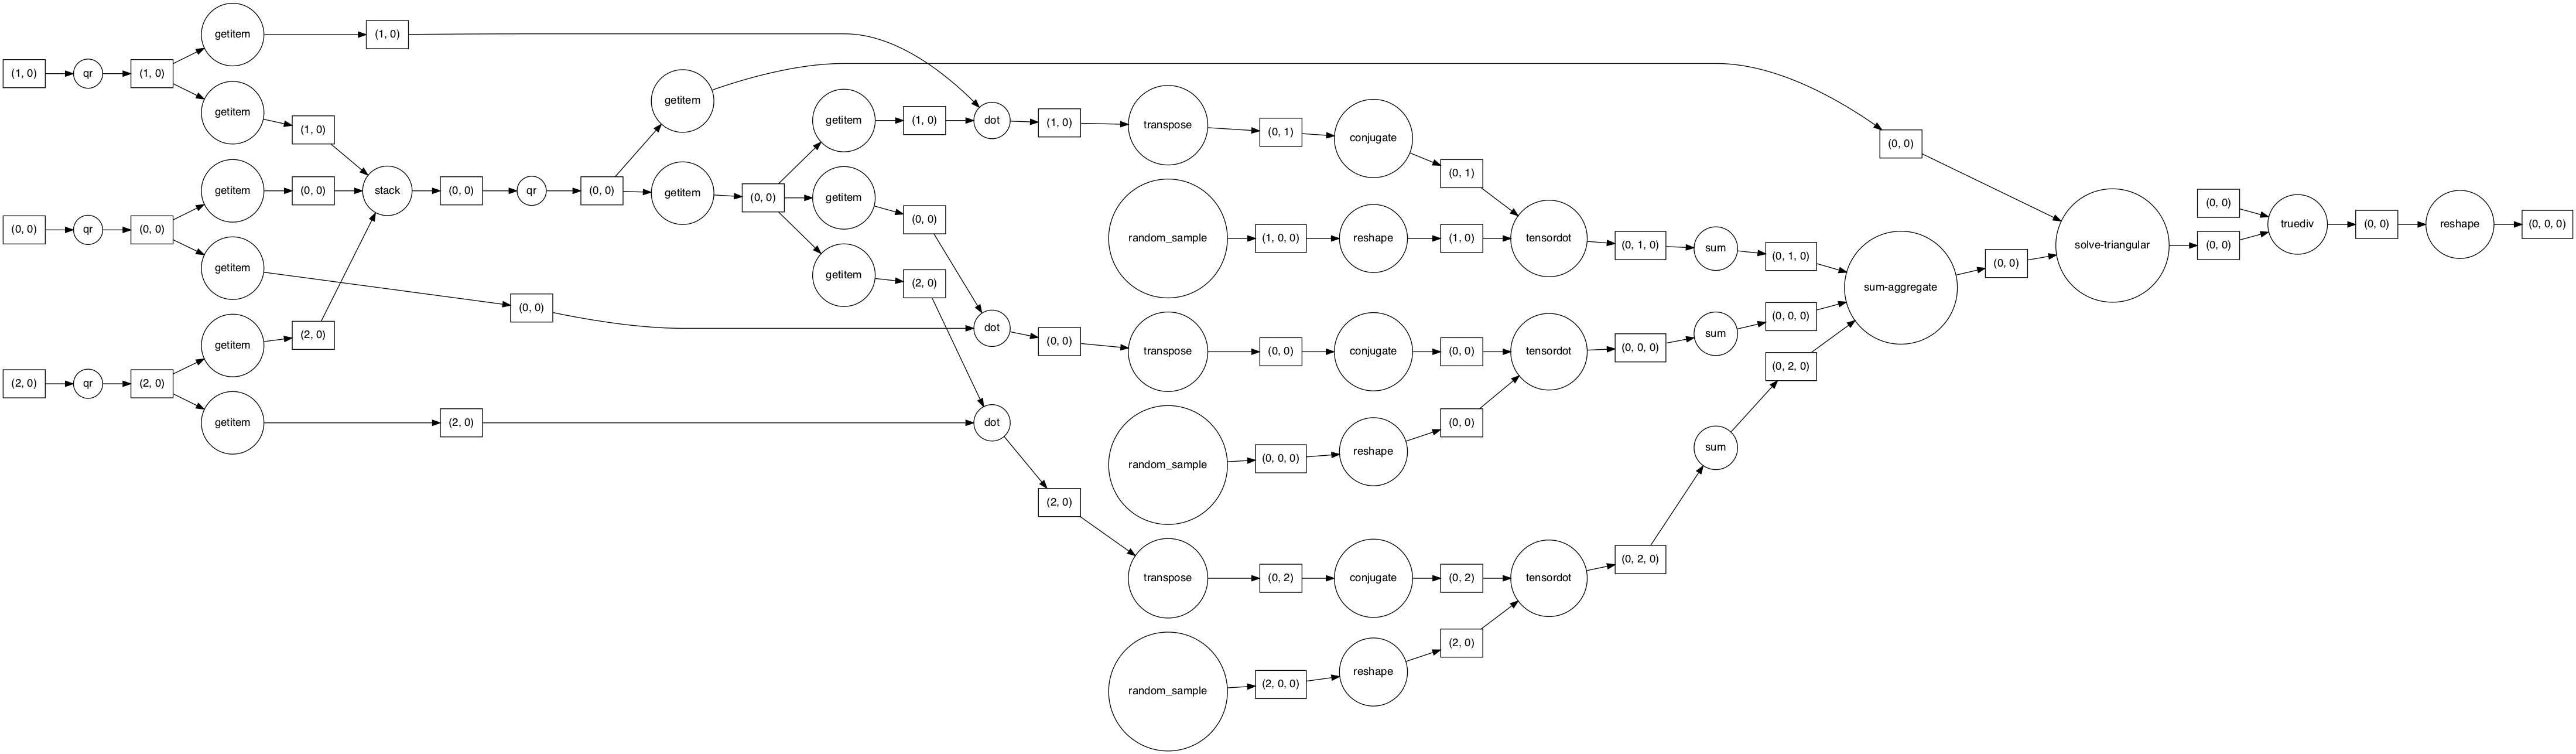

In [17]:
p = smol_da.polyfit(dim="ocean_time", deg=1, skipna=False)
dask.visualize(p, rankdir="LR")

Yes! we now see 3 tensordot tasks for this smaller problem instead of 1 in the previous buggy version.

## Attempt 2

In [18]:
# these are arguments provided to detrend
dim = "ocean_time"
deg = 1

p = da.polyfit(dim=dim, deg=deg, skipna=False)
p

<xarray.Dataset>
Dimensions:               (eta_rho: 489, xi_rho: 655, degree: 2)
Coordinates:
  * eta_rho               (eta_rho) int64 0 1 2 3 4 5 ... 484 485 486 487 488
  * xi_rho                (xi_rho) int64 0 1 2 3 4 5 ... 649 650 651 652 653 654
  * degree                (degree) int64 1 0
Data variables:
    polyfit_coefficients  (degree, eta_rho, xi_rho) float64 dask.array<chunksize=(2, 489, 655), meta=np.ndarray>

Computing works very well.

In [19]:
p.compute()

<xarray.Dataset>
Dimensions:               (eta_rho: 489, xi_rho: 655, degree: 2)
Coordinates:
  * eta_rho               (eta_rho) int64 0 1 2 3 4 5 ... 484 485 486 487 488
  * xi_rho                (xi_rho) int64 0 1 2 3 4 5 ... 649 650 651 652 653 654
  * degree                (degree) int64 1 0
Data variables:
    polyfit_coefficients  (degree, eta_rho, xi_rho) float64 1.756e-06 ... 0.5212

In [20]:
fit = polyval(chunked_dim, p.polyfit_coefficients)
fit

<xarray.DataArray (ocean_time: 2193, eta_rho: 489, xi_rho: 655)>
dask.array<sum-aggregate, shape=(2193, 489, 655), dtype=float64, chunksize=(8, 489, 655), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) int64 0 1 2 3 4 5 ... 2187 2188 2189 2190 2191 2192
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 482 483 484 485 486 487 488
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 648 649 650 651 652 653 654

In [21]:
fit.compute()

<xarray.DataArray (ocean_time: 2193, eta_rho: 489, xi_rho: 655)>
array([[[0.5057565 , 0.50509786, 0.5102827 , ..., 0.49117019,
         0.51031117, 0.50260723],
        [0.50364757, 0.4991787 , 0.49981748, ..., 0.50275095,
         0.49462038, 0.51076364],
        [0.48684994, 0.49536617, 0.48945836, ..., 0.49770676,
         0.49409571, 0.51575231],
        ...,
        [0.50350304, 0.49995467, 0.48793556, ..., 0.49612795,
         0.50501344, 0.49929657],
        [0.52682289, 0.50002593, 0.5005749 , ..., 0.49589506,
         0.49912113, 0.49788316],
        [0.50034415, 0.50321058, 0.49636848, ..., 0.49642915,
         0.4738819 , 0.5212416 ]],

       [[0.50575825, 0.50509024, 0.51028026, ..., 0.49118142,
         0.51029671, 0.50260979],
        [0.50365382, 0.49917254, 0.49981401, ..., 0.50274792,
         0.49462967, 0.51075928],
        [0.48685308, 0.49536343, 0.48946273, ..., 0.49770946,
         0.49410785, 0.51574038],
...
        [0.47291   , 0.49901151, 0.49777905, ..., 0.4923025 ,
         0.49520834, 0.50307457],
        [0.48737022, 0.48375397, 0.51454096, ..., 0.49594455,
         0.5089312 , 0.48435021],
        [0.51752643, 0.50832082, 0.48726435, ..., 0.48644143,
         0.50965033, 0.49448089]],

       [[0.50960524, 0.48840649, 0.50493417, ..., 0.51578852,
         0.47861806, 0.5082273 ],
        [0.51734334, 0.48567938, 0.49220683, ..., 0.49611448,
         0.51498191, 0.50122301],
        [0.49373412, 0.48936224, 0.49903297, ..., 0.50361574,
         0.52071202, 0.48960257],
        ...,
        [0.47289604, 0.49901108, 0.49778354, ..., 0.49230075,
         0.49520386, 0.50307629],
        [0.48735222, 0.48374655, 0.51454733, ..., 0.49594458,
         0.50893568, 0.48434403],
        [0.51753427, 0.50832316, 0.48726019, ..., 0.48643687,
         0.50966666, 0.49446867]]])
Coordinates:
  * ocean_time  (ocean_time) int64 0 1 2 3 4 5 ... 2187 2188 2189 2190 2191 2192
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 482 483 484 485 486 487 488
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 648 649 650 651 652 653 654

This ends up working well

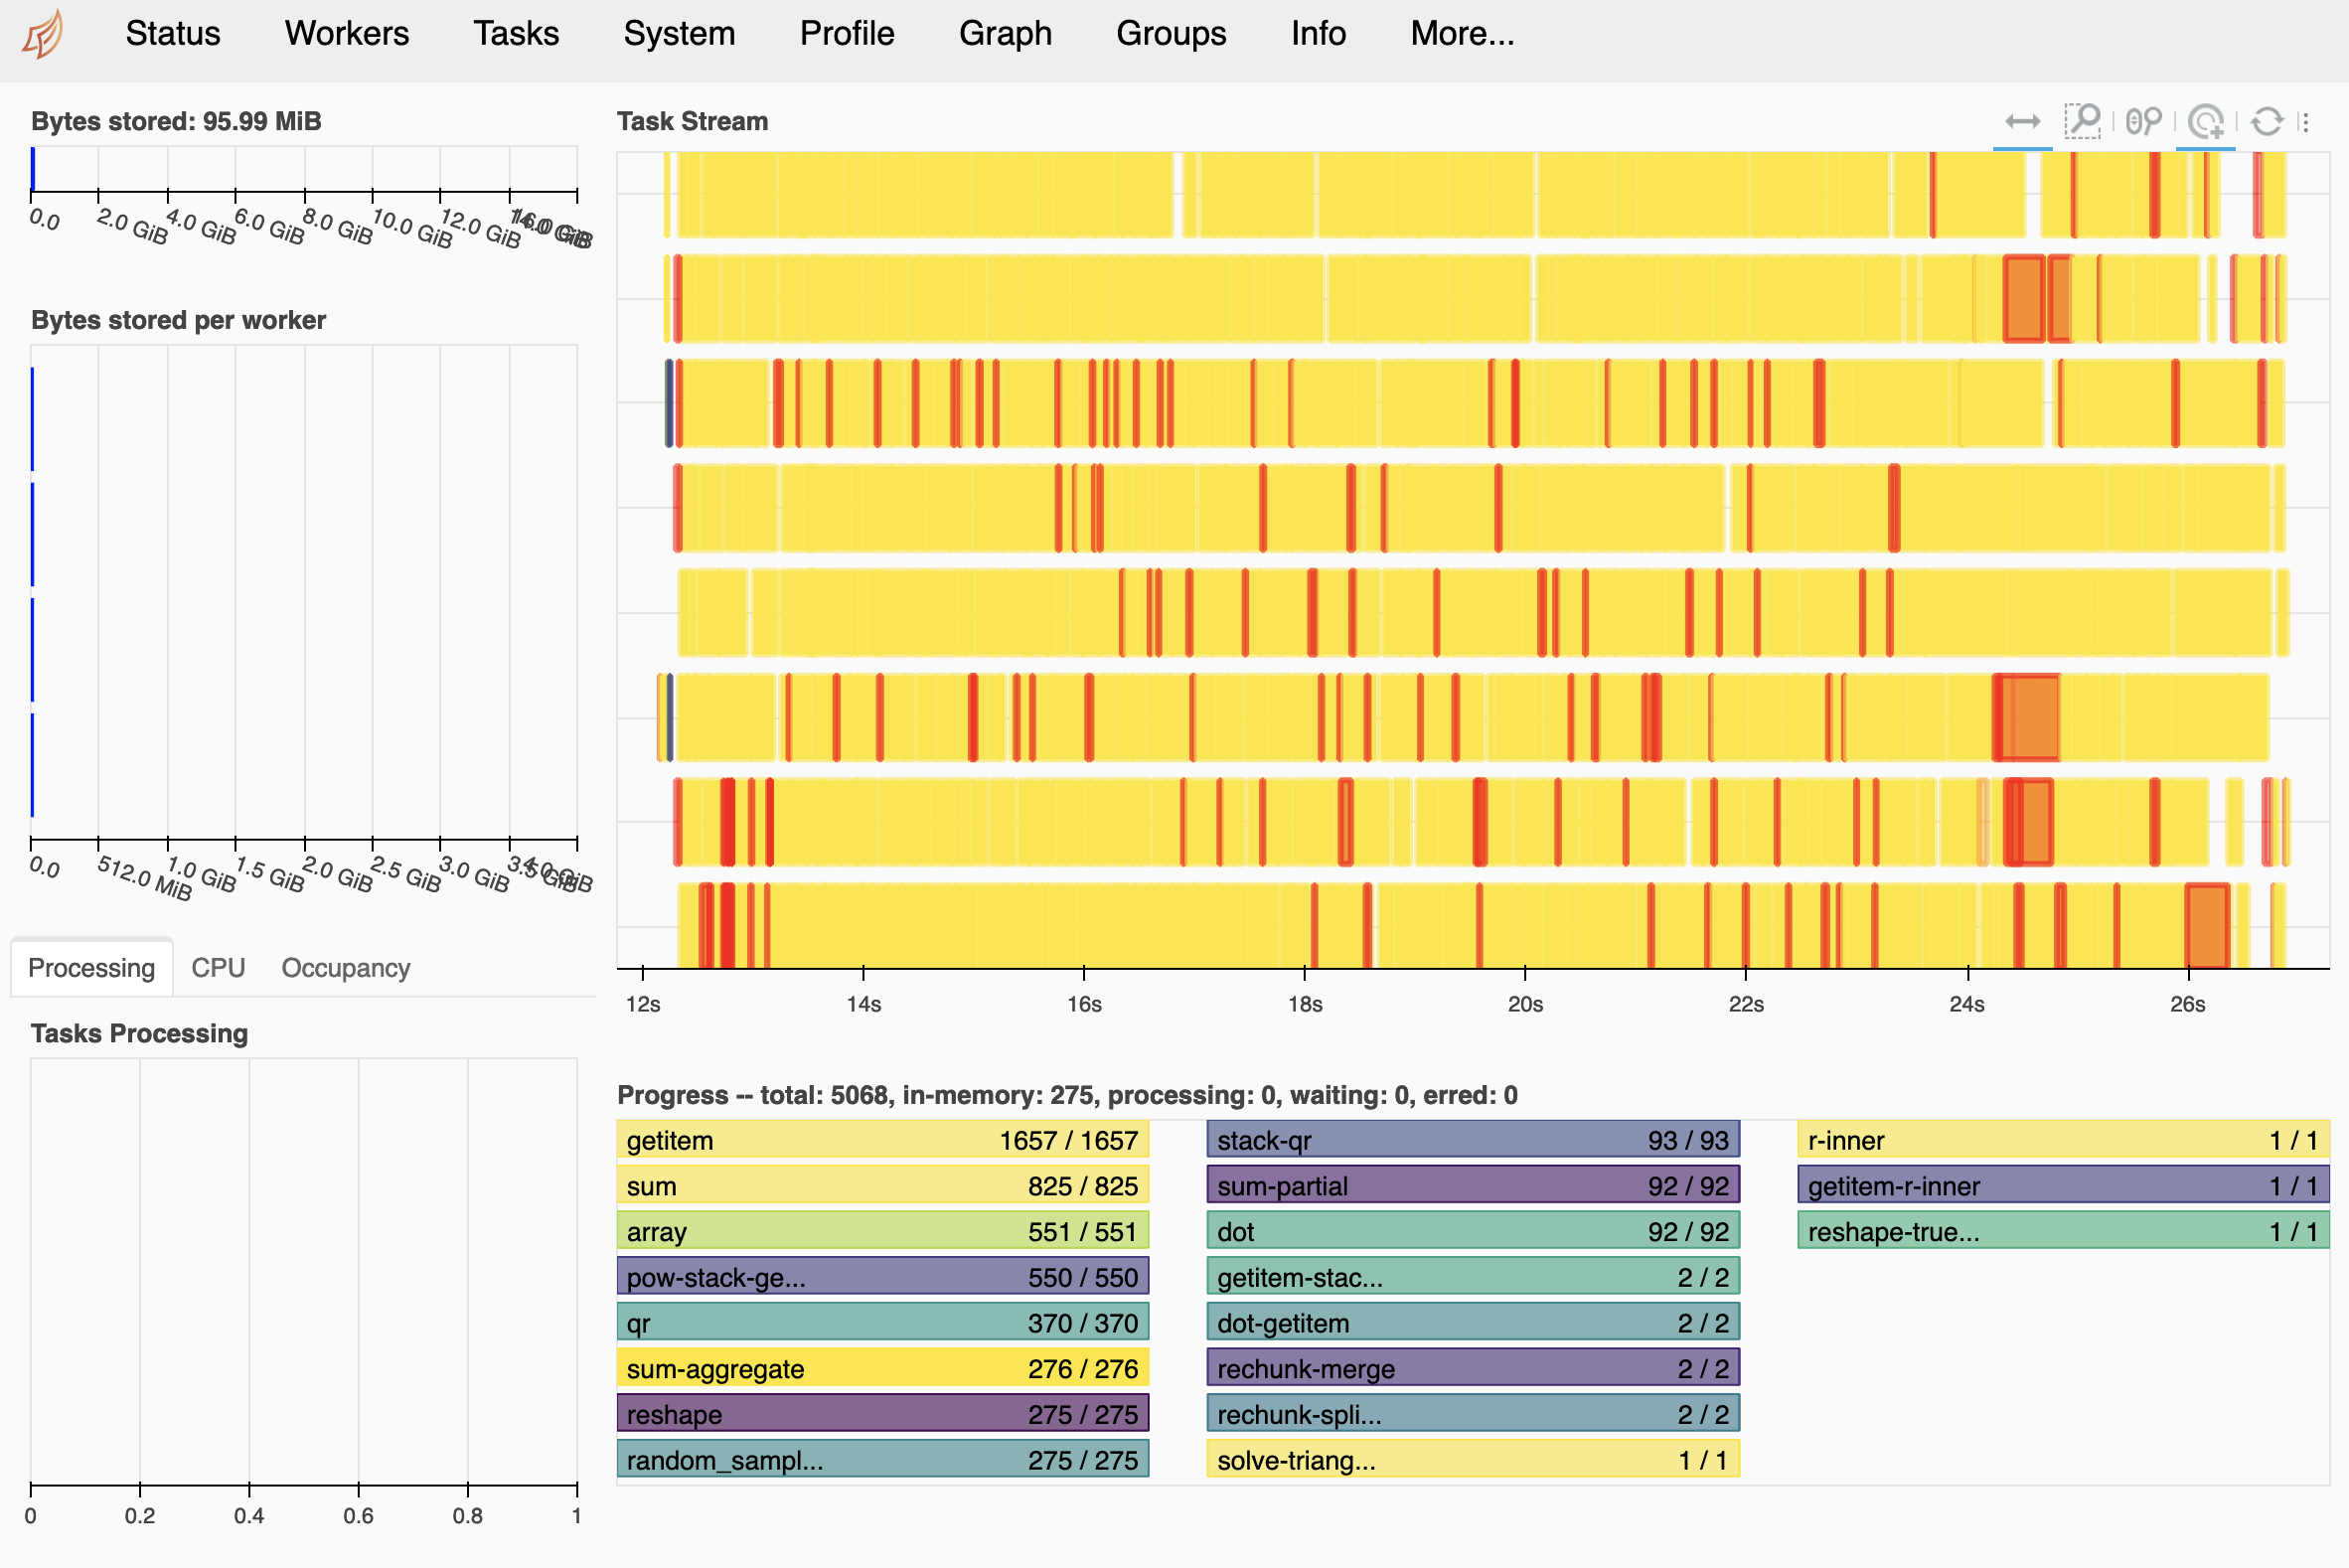

In [18]:
Image("../images/detrend-dask-dashboard-3.png")

## Finally

Here's everything put together

In [22]:
def polyval(coord, coeffs, degree_dim="degree"):
    x = coord.data

    deg_coord = coeffs[degree_dim]
    N = int(deg_coord.max()) + 1

    lhs = xr.DataArray(
        np.stack([x ** (N - 1 - i) for i in range(N)], axis=1),
        dims=(coord.name, degree_dim),
        coords={coord.name: coord, degree_dim: np.arange(deg_coord.max() + 1)[::-1]},
    )
    return (lhs * coeffs).sum(degree_dim)


# Function to detrend
# Modified from source: https://gist.github.com/rabernat/1ea82bb067c3273a6166d1b1f77d490f
def detrend_dim(da, dim, deg=1):
    """detrend along a single dimension."""
    # calculate polynomial coefficients
    p = da.polyfit(dim=dim, deg=deg, skipna=False)
    # first create a chunked version of the "ocean_time" dimension
    chunked_dim = xr.DataArray(
        dask.array.from_array(da[dim].data, chunks=da.chunksizes[dim]),
        dims=dim,
        name=dim,
    )
    fit = polyval(chunked_dim, p.polyfit_coefficients)
    # evaluate trend
    # remove the trend
    return da - fit


detrended = detrend_dim(da, dim="ocean_time")
detrended

<xarray.DataArray (ocean_time: 2193, eta_rho: 489, xi_rho: 655)>
dask.array<sub, shape=(2193, 489, 655), dtype=float64, chunksize=(8, 489, 655), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) int64 0 1 2 3 4 5 ... 2187 2188 2189 2190 2191 2192
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 482 483 484 485 486 487 488
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 648 649 650 651 652 653 654

In [ ]:
detrended.compute()

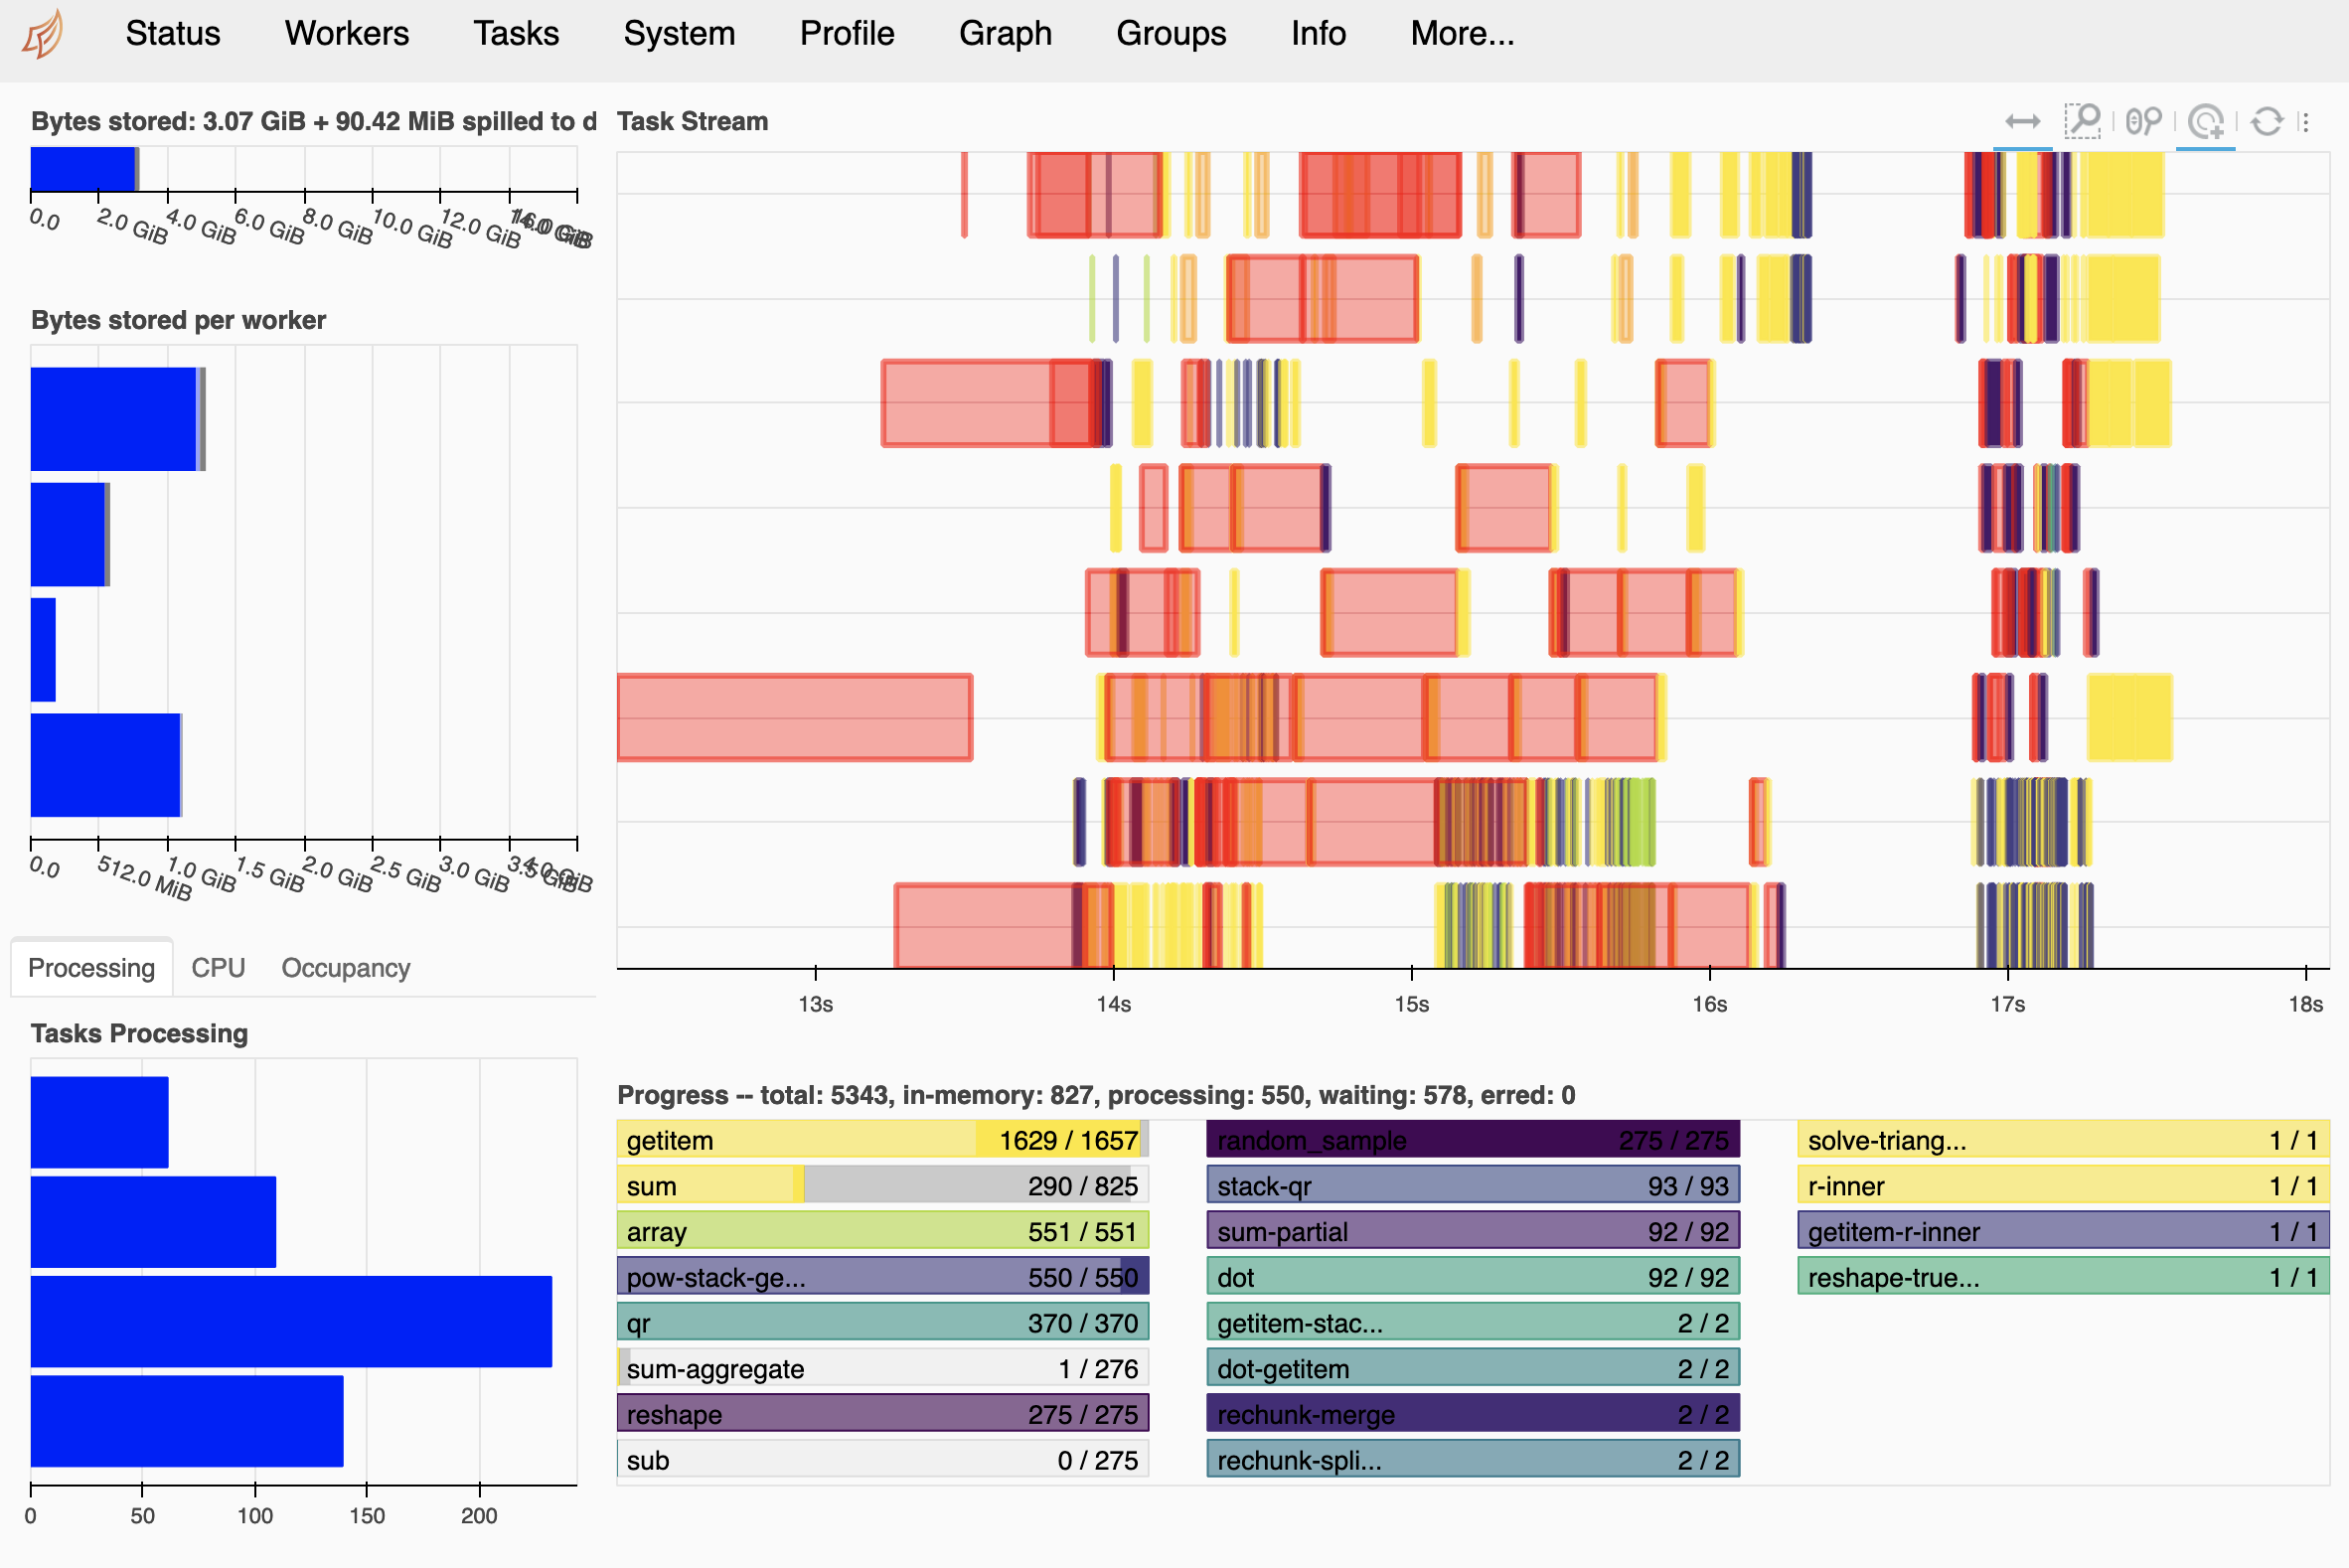

In [20]:
Image("../images/detrend-dask-dashboard-4.png")

It works!

## Summary

In this notebook, I explore the detrending problem a little bit to find what other challenges affect detrending workflows.
1. We use simple techniques like tracking chunk sizes and number of tasks to isolate a few problems.
1. Fixing those doesn't improve the calculation, so we then examine the dask  graph  for a smaller artificial problem that replicates the main issues.
1. This lets us trace the issue back to a serious [regression](https://github.com/dask/dask/issues/6916) in dask.
1. That issue has now been [fixed](https://github.com/dask/dask/pull/7980).
1. And things work!

## Future work

1. Some improvements to `xarray.polyval` are needed so that it can handle a chunked coordinate as input.
1. dask could also detect that a giant 5GB chunk is constructed by this line in polyval:
```python
(lhs * coeffs).sum(degree_dim)
```
and automatically avoid this problem by rechunking `lhs` prior to multiplying.